In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import itertools

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from keras.utils import to_categorical
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
def import_image_to_array(directory_path, size):
    image_arrays = []
    directory = os.listdir(directory_path)

    for image_name in directory:
        image = cv2.imread(directory_path + image_name)
        image = cv2.resize(image, size)
        image_arrays.append(image)
    return image_arrays

In [5]:
NORMAL_DIR = "D:/ilmu/kuliah/TA/cnn1/data/normal/"
COVID_DIR = "D:/ilmu/kuliah/TA/cnn1/data/covid/"

normal_dataset = import_image_to_array(NORMAL_DIR, (224,224))
covid_dataset = import_image_to_array(COVID_DIR, (224,224))

In [6]:
def white_balance(channel, perc = 0.05):
    mi, ma = (np.percentile(channel, perc), np.percentile(channel,100.0-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel

In [7]:
def clahe():
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
    return clahe

In [8]:
def image_enhancer(image_arrays):
    enchanced_images = []
    
    for image in image_arrays:
        image_WB  = np.dstack([white_balance(channel, 0.05) for channel in cv2.split(image)] )
        gray_image = cv2.cvtColor(image_WB, cv2.COLOR_RGB2GRAY)

        clahe_function = clahe()
        image_clahe = clahe_function.apply(gray_image)
        image = cv2.cvtColor(image_clahe, cv2.COLOR_GRAY2RGB)
        
        enchanced_images.append(image)
    
    return enchanced_images


In [9]:
normal_dataset_enhanced = image_enhancer(normal_dataset)
covid_dataset_enhanced = image_enhancer(covid_dataset)

(-0.5, 223.5, 223.5, -0.5)

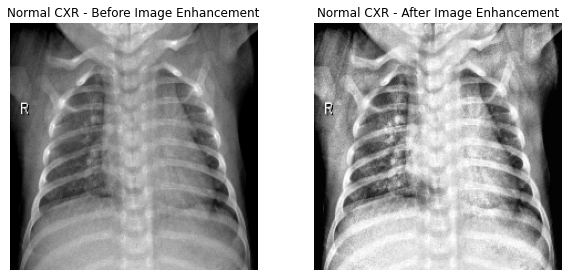

In [10]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.imshow(normal_dataset[100], cmap = "gray")
plt.title("Normal CXR - Before Image Enhancement")
plt.axis("off")

ax = plt.subplot(2, 2, 2)
plt.imshow(normal_dataset_enhanced[100], cmap = "gray")
plt.title("Normal CXR - After Image Enhancement")
plt.axis("off")

In [11]:
def normalizer(image_arrays):
    norm_image_arrays = []

    for image_array in image_arrays:
        norm_image_array = image_array / 255.0
        norm_image_arrays.append(norm_image_array)
    
    return norm_image_arrays

In [12]:
normal_dataset_normalized = normalizer(normal_dataset_enhanced)
covid_dataset_normalized = normalizer(covid_dataset_enhanced)

In [13]:
def split_and_merge_function(image_arrays, split_factor = [0.7, 0.15, 0.15]):
    datasets = {}   

    number_of_categories = len(image_arrays) 

    train_dataset, validation_dataset, test_dataset, train_labels, validation_labels, test_labels = [], [], [], [], [], []

    for image_array_id in range(number_of_categories):
        image_array = image_arrays[image_array_id]
        dataset = [[image_array[image_id], [image_array_id]] for image_id in range(len(image_array))]
        
        train_dataset.extend(np.array(dataset[ : int(np.around(len(dataset) * split_factor[0]))]))
        validation_dataset.extend(np.array(dataset[int(np.around(len(dataset) * split_factor[0])) : int(np.around(len(dataset) * (split_factor[0] + split_factor[1])))]))
        test_dataset.extend(np.array(dataset[int(np.around(len(dataset) * (split_factor[0] + split_factor[1]))) : ]))

        random.seed(42)
        random.shuffle(train_dataset), random.shuffle(validation_dataset), random.shuffle(test_dataset)

        train_data = [dataset[0] for dataset in train_dataset]
        train_labels = [dataset[1] for dataset in train_dataset]
        validation_data = [dataset[0] for dataset in validation_dataset]
        validation_labels = [dataset[1] for dataset in validation_dataset]
        test_data = [dataset[0] for dataset in test_dataset]
        test_labels = [dataset[1] for dataset in test_dataset]

    datasets['train_dataset'] = np.array(train_data)
    datasets['validation_dataset'] = np.array(validation_data)
    datasets['test_dataset'] = np.array(test_data)

    datasets['train_labels'] = to_categorical(np.array(train_labels))
    datasets['validation_labels'] = to_categorical(np.array(validation_labels))
    datasets['test_labels'] = to_categorical(np.array(test_labels))

    return datasets

In [14]:
image_arrays = [normal_dataset_normalized, covid_dataset_normalized]
datasets = split_and_merge_function(image_arrays, split_factor = [0.7, 0.15, 0.15])

In [15]:
train_dataset = datasets['train_dataset']
validation_dataset = datasets['validation_dataset']
test_dataset = datasets['test_dataset']
train_labels = datasets['train_labels'] 
validation_labels = datasets['validation_labels']
test_labels = datasets['test_labels']

In [37]:
print(train_dataset.shape)
print(train_labels.shape)

(840, 224, 224, 3)
(840, 2)


In [16]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.1))
    
    return data_augmentation

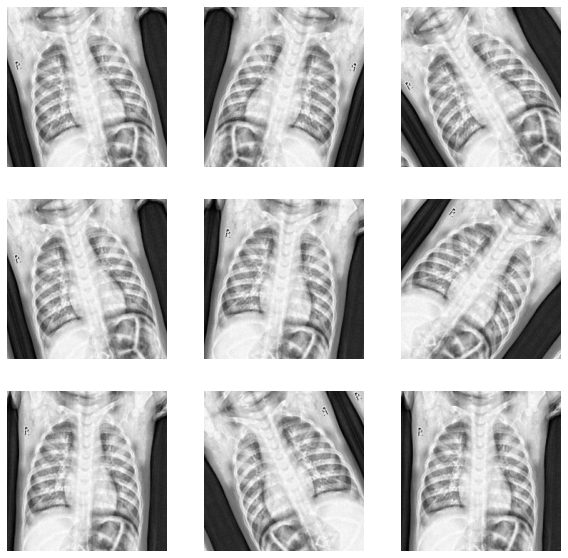

In [17]:
data_augmentation = data_augmenter()

plt.figure(figsize=(10, 10))
first_image = train_dataset[6]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    exp = tf.expand_dims(first_image, 0)
    augmented_image = data_augmentation(exp)
    plt.imshow(augmented_image[0])
    plt.axis('off')

In [19]:
def make_mobilenet_model(image_size, num_classes, data_augmentation = data_augmenter()):
    
    input_shape = image_size + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")

    base_model.trainable = False 
    inputs = tf.keras.Input(shape=input_shape) 
    x = data_augmentation(inputs)
    x = base_model(x, training=False) 
    x = GlobalAveragePooling2D()(x) 
    x = Dropout(0.2)(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 2
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    
    prediction_layer = Dense(units, activation=activation)
    
    outputs = prediction_layer(x)
    
    model = Model(inputs, outputs)
    
    return model

In [20]:
image_size = (224,224)
mobilenet_model = make_mobilenet_model(image_size, num_classes = 2)

mobilenet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0     

In [22]:
base_learning_rate = 0.001
optimizer = Adam(learning_rate = base_learning_rate)
initial_epochs = 50
batch_size = 64
loss = 'binary_crossentropy'
metrics = ['accuracy']
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=8, verbose=1, min_lr = 2e-6)
name = 'mobilenet'
tensorboard = TensorBoard(log_dir='logs/mobilenet/{}'.format(name))

mobilenet_model.compile(optimizer = optimizer,
              loss = loss,
              metrics = metrics)


In [23]:
mobilenet_history_freeze = mobilenet_model.fit(train_dataset, train_labels,
                                               batch_size = batch_size, 
                                               epochs = initial_epochs, 
                                               validation_data = (validation_dataset, validation_labels), 
                                               callbacks = [callback, reduce_lr,tensorboard], 
                                               shuffle = True)

Epoch 1/50
14/14 [==============================] - 27s 2s/step - loss: 0.8051 - accuracy: 0.5845 - val_loss: 0.5302 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 24s 2s/step - loss: 0.6025 - accuracy: 0.7595 - val_loss: 0.4455 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 24s 2s/step - loss: 0.5305 - accuracy: 0.7964 - val_loss: 0.4037 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 24s 2s/step - loss: 0.4384 - accuracy: 0.8464 - val_loss: 0.3649 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 25s 2s/step - loss: 0.3951 - accuracy: 0.8595 - val_loss: 0.3369 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 24s 2s/step - loss: 0.3791 - accuracy: 0.8679 - val_loss: 0.3231 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 7/50
14/14 [==============================] - 25s 2s/step - loss: 0.3509 - a

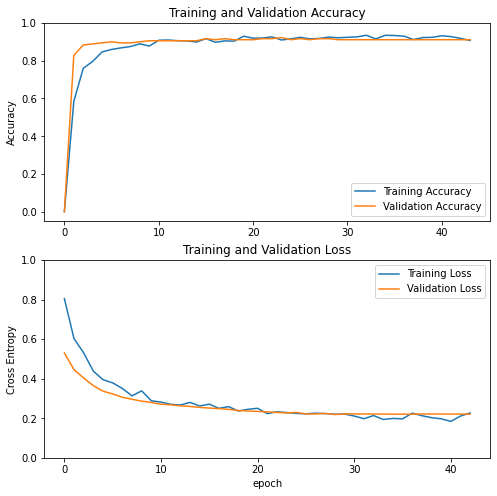

In [25]:
acc = [0.] + mobilenet_history_freeze.history['accuracy']
val_acc = [0.] + mobilenet_history_freeze.history['val_accuracy']

loss = mobilenet_history_freeze.history['loss']
val_loss = mobilenet_history_freeze.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
base_mobilenet_model = mobilenet_model.layers[2] # MobileNetV2 Architecture
base_mobilenet_model.trainable = True


fine_tune_at = 120
for layer in base_mobilenet_model.layers[:fine_tune_at]:
    layer.trainable = True

optimizer = Adam(learning_rate = 0.1 * base_learning_rate)
batch_size = 64
loss = 'binary_crossentropy'
metrics = ['accuracy']
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=8, verbose=1, min_lr = 2e-6)

mobilenet_model.compile(optimizer = optimizer,
                        loss = loss,
                        metrics = metrics)

In [27]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

mobilenet_history_fine = mobilenet_model.fit(train_dataset, train_labels,
                                             epochs = total_epochs,
                                             batch_size = batch_size,
                                             initial_epoch = mobilenet_history_freeze.epoch[-1],
                                             callbacks = [callback, reduce_lr, tensorboard], 
                                             validation_data = (validation_dataset, validation_labels),
                                             shuffle=True)

Epoch 43/80
14/14 [==============================] - 73s 5s/step - loss: 1.0756 - accuracy: 0.7012 - val_loss: 0.4483 - val_accuracy: 0.7889 - lr: 1.0000e-04
Epoch 44/80
14/14 [==============================] - 57s 4s/step - loss: 0.2980 - accuracy: 0.8857 - val_loss: 0.2314 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 45/80
14/14 [==============================] - 55s 4s/step - loss: 0.1905 - accuracy: 0.9262 - val_loss: 0.1929 - val_accuracy: 0.9111 - lr: 1.0000e-04
Epoch 46/80
14/14 [==============================] - 54s 4s/step - loss: 0.1480 - accuracy: 0.9488 - val_loss: 0.4437 - val_accuracy: 0.8389 - lr: 1.0000e-04
Epoch 47/80
14/14 [==============================] - 54s 4s/step - loss: 0.2477 - accuracy: 0.9095 - val_loss: 0.3392 - val_accuracy: 0.8556 - lr: 1.0000e-04
Epoch 48/80
14/14 [==============================] - 54s 4s/step - loss: 0.1861 - accuracy: 0.9429 - val_loss: 0.1942 - val_accuracy: 0.9111 - lr: 1.0000e-04
Epoch 49/80
14/14 [==============================] -

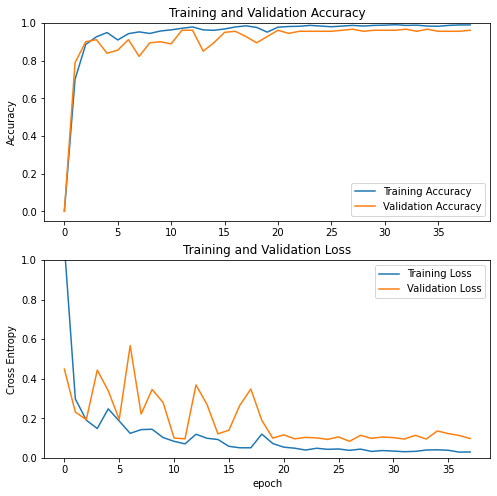

In [28]:
acc = [0.] + mobilenet_history_fine.history['accuracy']
val_acc = [0.] + mobilenet_history_fine.history['val_accuracy']

loss = mobilenet_history_fine.history['loss']
val_loss = mobilenet_history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
mobilenet_model.save("cnn_with_mobilenet_netwrok_after_fine_tuning.h5")

In [18]:
mobilenet_model = load_model('cnn_with_mobilenet_netwrok_after_fine_tuning.h5')


In [19]:
test_prediction = mobilenet_model.predict(test_dataset, batch_size=64)
test_prediction_class = np.argmax(test_prediction, axis=1)
test_labels_class = np.argmax(test_labels, axis=1)

print(classification_report(test_labels_class, test_prediction_class, target_names=["normal", "covid"]))

3/3 [==============================] - 3s 723ms/step
              precision    recall  f1-score   support

      normal       0.90      0.80      0.85        90
       covid       0.82      0.91      0.86        90

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180



In [ ]:
#Confusion matrix

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          target_names = ['Normal','Covid']):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names = target_names

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

3/3 [==============================] - 2s 777ms/step


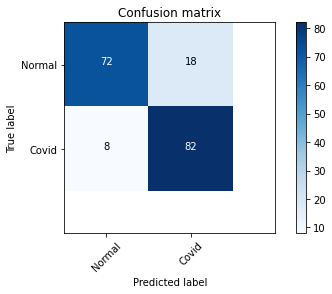

In [21]:

testing_predictions = mobilenet_model.predict(test_dataset, batch_size=64)

testing_predictions_classes = np.argmax(testing_predictions, axis = 1)
testing_labels_classes = np.argmax(test_labels, axis =1)

confusion_mtx = confusion_matrix(testing_labels_classes, testing_predictions_classes)


plot_confusion_matrix(confusion_mtx, classes = range(3)) 

In [53]:
print("confusion matrix: ")
print(confusion_mtx)

confusion matrix: 
[[72 18]
 [ 8 82]]


In [48]:
predictions = mobilenet_model.predict(test_dataset, batch_size = 64)
prediction_classes = np.argmax(predictions, axis = 1)
true_classes = np.argmax(test_labels, axis = 1)

class_names = {0: "Normal", 1: "COVID-19"}


3/3 [==============================] - 2s 739ms/step


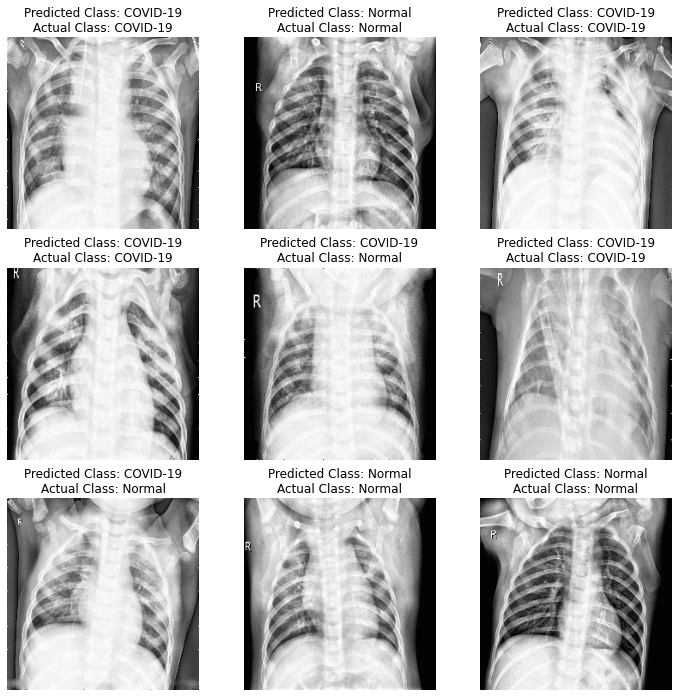

In [35]:
plt.figure(figsize=(12, 12))
for image in range(9):
    ax = plt.subplot(3, 3, image + 1)
    plt.imshow(test_dataset[image], cmap = "gray")
    plt.title("Predicted Class: " + str(class_names[prediction_classes[image]]) + "\n" +"Actual Class: " + str(class_names[true_classes[image]]))
    plt.axis("off")